# Heliconius Average Edit Viewer

This notebook will aggregate edits for a window within the dna

## Initial Configurations
Edit configurations below

In [1]:
import os
from pathlib import Path
from dataclasses import dataclass

import torch

from gtp.configs.loaders import load_configs
from gtp.configs.project import GenotypeToPhenotypeConfigs
from gtp.dataloading.path_collectors import (
    get_experiment_directory,
    get_post_processed_genotype_directory,
)
from gtp.dataloading.tools import collect_chromosome
from gtp.models.net import SoyBeanNet
from gtp.options.process_attribution import ProcessAttributionOptions

# SPECIFY GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = "cuda"


class ExperimentState:
    def __init__(
        self,
        wing: str,
        species: str,
        color: str,
        chromosome: int,
        exp_name: str,
        config_path: str,
    ):
        self.wing = wing
        self.species = species
        self.color = color
        self.chromosome = chromosome
        self.exp_name = exp_name
        self.configs: GenotypeToPhenotypeConfigs = load_configs(config_path)
        self.model = None
        self.camids = None
        self.data = None

        self.load_data_and_model()

    def load_data_and_model(self):
        match self.exp_name:
            case "base":
                drop_out_prob = 0.75
                out_dims = 1
                out_dims_start_idx = 0
                insize = 3
                hidden_dim = 10
            case "pca_10":
                drop_out_prob = 0.75
                out_dims = 10
                out_dims_start_idx = 0
                insize = 3
                hidden_dim = 10
            case _:
                raise NotImplementedError(
                    f"Experiment {self.exp_name} isn't implemented for this visualization. Please create a case and update configs."
                )

        opts: ProcessAttributionOptions = ProcessAttributionOptions(
            drop_out_prob=drop_out_prob,
            out_dims=out_dims,
            out_dims_start_idx=out_dims_start_idx,
            insize=insize,
            hidden_dim=hidden_dim,
            species=self.species,
            chromosome=self.chromosome,
            color=self.color,
            wing=self.wing,
            exp_name=self.exp_name,
        )

        processed_genotype_dir = (
            get_post_processed_genotype_directory(self.configs.io)
            / self.configs.experiment.genotype_scope
        )

        # Collect genotype data
        self.camids, self.data = collect_chromosome(
            processed_genotype_dir, self.species, self.chromosome
        )

        self.model = SoyBeanNet(
            window_size=self.data.shape[1],
            num_out_dims=opts.out_dims,
            insize=opts.insize,
            hidden_dim=opts.hidden_dim,
            drop_out_prob=opts.drop_out_prob,
        )

        experiment_dir = get_experiment_directory(
            self.configs.io,
            species=self.species,
            wing=self.wing,
            color=self.color,
            chromosome=self.chromosome,
            exp_name=self.exp_name,
        )

        self.model.load_state_dict(
            torch.load(experiment_dir / "model.pt", weights_only=True)
        )
        self.model = self.model.to(device)
        self.model.eval()


"""
EDIT HERE
"""
experiment_state = ExperimentState(
    wing="forewings",
    species="erato",
    color="total",
    chromosome=10,
    exp_name="pca_10",
    config_path=Path("../configs/default.yaml"),
)

## Dashboard
Explore the model below

In [153]:
import ipywidgets as widgets
from copy import copy
from dataclasses import dataclass

from ipywidgets import VBox, HBox
import plotly.graph_objs as go
import numpy as np
from captum.attr import LRP

def get_model_input(camid):
    input_idx = np.where(experiment_state.camids == camid)[0][0]
    x = experiment_state.data[input_idx]
    x = torch.tensor(x).unsqueeze(0).unsqueeze(0).float().to(device)
    return x


def get_model_output(input_x):
    with torch.no_grad():
        return experiment_state.model(input_x)

test_camid = experiment_state.camids[1]
with torch.no_grad():
    test_model_input = get_model_input(test_camid)
    test_model_output = get_model_output(test_model_input)
test_model_output.shape

torch.Size([1, 10])

In [107]:
import pandas as pd

pca_w_tmp = pd.read_csv("total_w.csv")
pca_w_tmp.shape

(270000, 473)

In [116]:
with open("total_w_center.csv", "r") as f:
    pca_center = np.array([float(x.strip()) for x in f.readlines()])

pca_center.shape

(270000,)

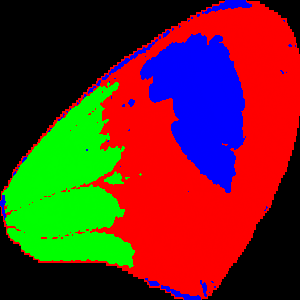

In [117]:
pca_tmp = [-80.7558559482329,6.63936621572295,-14.4402046369059,38.2407325867839,-22.8540761201316,11.0934434964822,-9.12789574212891,12.6162949733854,-4.37005712172482,6.87081544035249,-6.04678312170381,6.08061604213924,-6.84554776779732,24.569456275103,-1.13608477090475,11.532229357559,0.254936947099972,-8.93400644263465,10.8253173745481,-4.41278732292024,6.96238859586677,-13.6378844970503,0.143328093496675,-3.27552982286469,0.830045896638575,-0.021237841290723,2.88270614680794,-3.25455974786879,10.8764886962566,-7.24883665328143,2.25117179524387,8.79874332742919,-4.08036688450429,2.22756783754657,2.14497008024107,4.6441111727697,-9.35112669629847,7.1599255799403,-14.4047282011459,1.13684737753451,-2.01418408540327,9.20535101221266,-2.23472045098742,1.33643371734373,-1.1995576549548,3.16436444221229,-4.48128485843611,3.16926371393882,-1.52096083177178,0.708601069687936,-9.44701868111,9.19902655390853,-0.0225687036299523,3.71865185577759,-1.19453350250851,0.37987587358756,-2.69988484026472,4.20014709445809,3.24628503286789,-8.28441335477536,2.06263909629307,-0.826631982340351,-1.40170785588532,3.85628125056539,0.777482560850068,-4.23576198493305,-1.7129126784346,5.28030390607831,6.71849808282984,-1.54477162276443,-0.0270191720851527,4.44911737830669,1.05565123151054,-2.67116663073805,-0.152949876821112,-0.558954202081851,3.625695928778,3.53717147357224,1.06972517221145,-2.49087116614234,-0.217689152855048,-1.06906896414202,4.44487556629801,0.267046666416322,0.421901824521146,-1.56825450318932,-0.192482143763603,-5.40014957569601,4.4431649653352,-1.17271730735152,0.0746470891827213,-1.64797519095669,0.961164004790897,-1.1478504139814,2.54831392772521,-3.99604169108907,2.8486022556247,-0.140605909088304,5.48438302564991,-6.14984925556139,1.22618269080989,-0.329248570711388,0.503955565783202,-1.45510674680218,1.86494088326674,-0.579038901825537,2.07429670539947,-1.30749055091086,6.25424900260852,-0.175992251228247,0.844633139817279,-0.535868775707094,1.94163981442379,-0.679376080494472,0.900896437045942,0.111940817651436,-4.46059768488332,5.71664976799743,-0.36009715807353,5.74477494851683,3.22971287022036,-1.14721319992754,1.48048726046707,-5.4336397798659,-2.41384597094801,2.10079212113468,-4.42662789129737,-1.65732156935756,5.22407838042826,6.5923815295639,-4.35182258633187,1.90840188995018,0.0579065646793929,0.51868882298374,-1.62538782294791,2.28819451720856,0.271769607267599,2.1823841704837,-2.42527952141939,2.83033065710899,-2.20033975858057,-1.48378724288924,1.11060780467175,0.913034908263019,1.96268830213675,-1.4002380554155,-1.41419150282171,2.14852385628814,4.08198954434662,0.728554018059022,-5.15531573881541,3.20933430408427,-1.97102960895182,-0.0634284691995427,-0.976486086341102,-0.464729173408142,4.53645960821982,0.553931167532069,0.642702886271546,-2.74357653393002,-0.329241941687826,1.9913246646285,1.24621620514487,0.655190572211202,-0.676121069214172,-3.96719363080681,3.13242517491328,4.44086672870368,-2.60116410339236,-2.89406684355691,-5.89241465677202,1.02343743165691,2.86354752601266,0.117248347766757,-2.59935008113712,-1.99696501707935,-3.15712482053096,4.59708270476089,0.761945142701218,0.224022150129585,2.0023980081646,-3.83948761092928,-0.606569251112568,5.27936017220586,3.2378655342217,-1.08154329160153,-3.41710446102781,-2.61120731181007,1.73896294408185,4.04920582518755,0.423840784016592,-3.93831752506435,-2.36118389681486,-5.30934393888611,0.371291285899682,2.40281533808715,-2.32466188688476,-2.82389711421745,-0.801015240111989,-1.28764573198741,1.45116990198905,2.07697238305669,0.161911604847961,2.20326496287428,-4.33101923118649,-3.50728172068818,-1.37410748881216,5.29143714957597,0.0798770064912464,0.623845516912686,3.43501729643235,-2.02543105575634,-3.71682561960767,-0.834616447883753,0.78858032933934,4.82729419403302,2.42678980135985,1.40020698729371,-2.02106746325531,-3.86437314288772,1.06397514529849,2.43075376652003,0.817153688842618,1.86371720898249,2.42033316107907,-1.01080149699784,-0.0106151080718516,-3.1404742325975,1.57837494812588,0.69942732811025,3.31164008803627,3.49827513859304,-1.36838469808839,-4.35287612224126,-1.86602571790182,0.109419430450613,3.0267773964577,2.53933024326794,1.36248356281555,-4.28500299077325,-0.834759418897837,-0.416465361377647,-1.48098923845691,-1.96651585756335,1.44544639451353,3.82436180602986,1.43921106320055,3.32227686167333,-0.197303248236538,-0.614241954772202,-1.42148615013373,-2.50618241462483,-4.77584447078602,3.45903475772545,2.67168109331475,0.243245876103452,2.6231565429654,-0.923580325092925,-4.56954338497848,-2.5744466367495,2.55016310881486,3.99662085829223,2.41729172424475,3.54275220768908,-4.22595800494566,-1.62896330521256,-1.21371602901771,-0.783544093224144,-1.55008990052687,4.62873312594117,1.98576106101628,2.34424182355241,3.19636033538073,-2.93890541546029,-2.85406271834361,-2.90963928414592,-1.00434715283187,-4.88843373169067,2.04198915468967,3.17480295189959,1.98145278912807,0.325675758860117,0.236207529795684,-2.52580749077041,-0.968162487578114,-1.92038464629629,-6.14989344552738,1.34590009137185,2.62861703282762,5.92468789751924,0.126735041175384,-5.89415081789854,-0.585981711387921,-2.87887214770266,-0.692335563664403,-1.66541412645918,-3.54700349481586,9.98280967323314,7.41834012734641,2.04995650386725,4.03851704681952,-2.04004069850499,-10.17026723297,-1.54338341896799,1.84961133404337,1.96502596875785,3.47053438270287,5.74872875712052,1.84232295074296,-0.111609059399083,-0.979974455717451,-4.55555181149203,-3.10702354914639,-1.59066354905808,3.14554300199801,3.34845943664229,1.68850594079899,7.63122554020852,-0.407396077507195,-1.35969238522381,-0.382404953913835,-3.8051979831939,-0.325818204656189,-2.82732284930605,0.688339614436139,3.26147922794567,0.00842679161804664,4.51172732674423,-3.02673809336959,-3.00320390911478,-1.35964084861881,-0.396144207002086,-6.23536629744474,2.3573754697867,0.0882596358236238,2.36688484834861,4.40189077189513,2.93723770826055,-0.667515398706902,-2.4200928768391,-1.77585878667248,-2.85410653156951,1.28625030355189,1.66918711680727,0.12727610645533,0.587912671124499,1.16344816049353,0.340536691628284,2.23437854013628,-0.850348793203871,-0.384536493511732,-0.408817149700967,-6.21849088922739,5.08724832561994,0.615201477618054,2.003393404483,2.42689418440444,-1.07974121293842,-2.78443864534517,-0.660814317003513,-1.95335703355629,-2.49373248149667,-3.30115813281338,8.30391213054543,2.33912983689486,1.19761209096912,1.02471331099363,2.54990879961042,-4.59143462664837,-1.3220512667151,-1.07199762537434,-2.16434810655832,4.59385832867372,3.54776999996995,2.81621976693401,1.84430219202562,-4.95782349969994,-1.05850546093818,-4.49365946420854,-0.865376051885892,0.848778892526736,4.35934428480245,6.0321225687862,4.37846447486659,-4.31660417582787,-3.03711446163551,-0.852529475517817,-7.40950969453162,2.24945503975884,2.00848449656238,0.054223778988978,0.340177590810927,0.875901290096315,-1.32000926734769,-1.7049915617377,-2.28633636343661,-4.47203001784753,1.66486649474883,3.57518930727052,1.35242537944911,0.606979670297053,0.344785611233641,0.0581721051836693,-2.91425389606801,-1.55315654588094,-3.10716317240521,-1.14185556750958,1.67871657729761,2.11144968510261,1.72580297379722,1.36472327232582,-0.84123309997193,-5.91325762971616,4.02877713621743,3.62524030782261,0.781030038088874,3.10354811151707,1.04001117078253,-4.4663042970323,-2.94523114383953,-5.54153139826476,0.579900803549049,0.888461257619165,10.1142345377305,-1.51536415056239,-4.40248015172122,-3.89747658644835,3.95041181022385,1.28362063238487,1.05250515465484,2.73571291277991,-1.71191114014434,-0.748443857916304,-3.52044868724009,2.10312259336087,5.07326371707115,0.9328561972204,-3.53505065265129,-4.03741418047429,2.46122803868205,0.603287476391911,1.14961557876122,-5.1968894673129,-2.92239839925346,2.17074389759187,0.352221078097849,0.0160793631525528,-0.773633045469951,-1.50499359994342,4.26840214450886,0.15362246307448,0.805917736017453,-2.43266867730524,5.47891792686674,-5.99292747389775,-0.630579428635143,0.652833872371134,-7.05417238981029,3.1534473216787,-1.19600812047315,3.18890098441509,-2.20193926149928,1.29699188226376,-0.351204738190083,2.59054511517788,-3.73754626226314,0.214456528286994,-0.297617226613339,1.02295107427006,-0.0988399730884992,0.767261448733714,-1.37830960094968,-1.47886802630282e-13]
pca_tmp = np.array(pca_tmp)
pca_w_tmp_np = pca_w_tmp.to_numpy()

results = (pca_w_tmp_np @ pca_tmp.T) + pca_center
results = results.reshape(3, 300, 300)
results = np.transpose(results, axes=(1, 2, 0))
results_img = Image.fromarray((results * 255).astype(np.uint8))
results_img

caching camids:   0%|          | 0/484 [00:00<?, ?it/s]

caching camids: 100%|██████████| 484/484 [00:00<00:00, 3257.83it/s]


PCA projection matrix shape: (270000, 480)
CAM016020


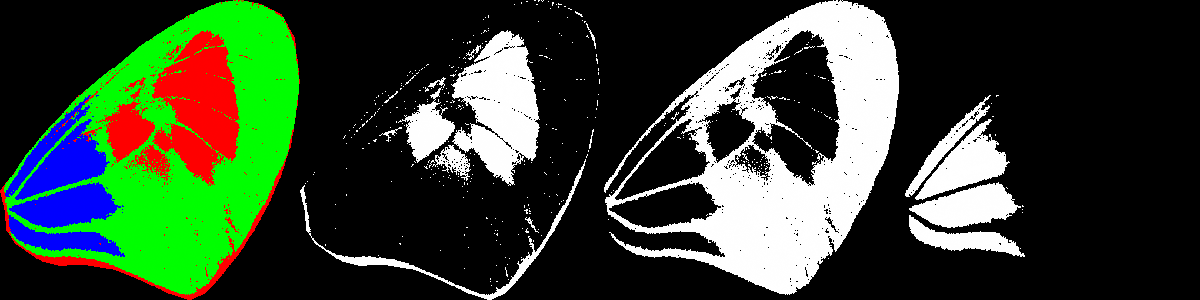

In [154]:
from io import BytesIO
from ipywidgets import HBox
import pandas as pd
from tqdm import tqdm

from PIL import Image
from matplotlib import cm

from gtp.dataloading.path_collectors import get_post_processed_phenotype_directory

cfgs = experiment_state.configs
species = experiment_state.species
wing = experiment_state.wing
color = experiment_state.color
phenotype_folder = get_post_processed_phenotype_directory(cfgs.io)
pca_pheno_df = pd.read_csv(phenotype_folder / f"{species}_{wing}_{color}" / "data.csv")

camid_pca_map = {}
for camid in tqdm(experiment_state.camids, desc="caching camids"):
    results = pca_pheno_df.loc[pca_pheno_df.camid == camid]
    pca_vector = results.iloc[:1, 1:].to_numpy()
    
    camid_pca_map[camid] = pca_vector

if color == "total":
    color = "color_total"
proj_matrices_dir = Path(cfgs.io.default_root, "dna/projection_matrices")
pca_df = pd.read_csv(proj_matrices_dir / f"{species}_{wing}_{color}.csv")
pca_w = pca_df.to_numpy()
print(f"PCA projection matrix shape: {pca_w.shape}")

pca_center_df = pd.read_csv(proj_matrices_dir / f"{species}_{wing}_{color}_center.csv")
pca_center = pca_center_df.to_numpy()

    
def get_org_pca_vector(camid):
    return camid_pca_map[camid]


def get_proj_matrix():
    return pca_w

def get_pca_center():
    return pca_center

def create_proj_img(pca_w, pca_vector, pca_center,return_raw=False):
    proj_img_m = (pca_w @ pca_vector.T) + pca_center
    if experiment_state.color == "total":
        proj_img_m = proj_img_m.reshape(3, 300, 300)  # Range between [-1, 1]
        proj_img_m = np.transpose(proj_img_m, axes=(1, 2, 0))
    else:
        proj_img_m = proj_img_m.reshape(300, 300)  # Range between [-1, 1]
        
    if return_raw:
        return proj_img_m
        
    # proj_img_m += 1
    # proj_img_m /= 2  # [0, 1]
    proj_img_m[proj_img_m <= 0] = 0
    proj_img_m[proj_img_m > 0] = 1
    im = Image.fromarray(np.uint8(proj_img_m * 255))

    return im

def raw_to_image(raw_img):
    return Image.fromarray(np.uint8(raw_img * 255))

def raw_to_images(raw_img):
    img0 = np.uint8(raw_img[:, :, 0] * 255)
    img1 = np.uint8(raw_img[:, :, 1] * 255)
    img2 = np.uint8(raw_img[:, :, 2] * 255)
    img0 = np.stack([img0]*3, axis=-1)
    img1 = np.stack([img1]*3, axis=-1)
    img2 = np.stack([img2]*3, axis=-1)
    
    all = np.uint8(raw_img * 255)
    
    return Image.fromarray(np.concatenate([all, img0, img1, img2], axis=1))

def get_proj_img(pca_vector, return_raw=False):
    pca_w = get_proj_matrix()
    pca_center = get_pca_center()

    im = create_proj_img(pca_w, pca_vector, pca_center, return_raw=return_raw)

    return im

def get_model_pca_view(input_x, camid):
    output = get_model_output(input_x)
    pca_output = output.detach().cpu().numpy()
    D = pca_output.shape[-1]
    pca_vector = get_org_pca_vector(camid)
    pca_vector[:, :D] = pca_output
    return pca_vector


org_pca_vec = get_org_pca_vector(test_camid)
org_img = get_proj_img(org_pca_vec, return_raw=True)

print(test_camid)
raw_to_images(org_img)

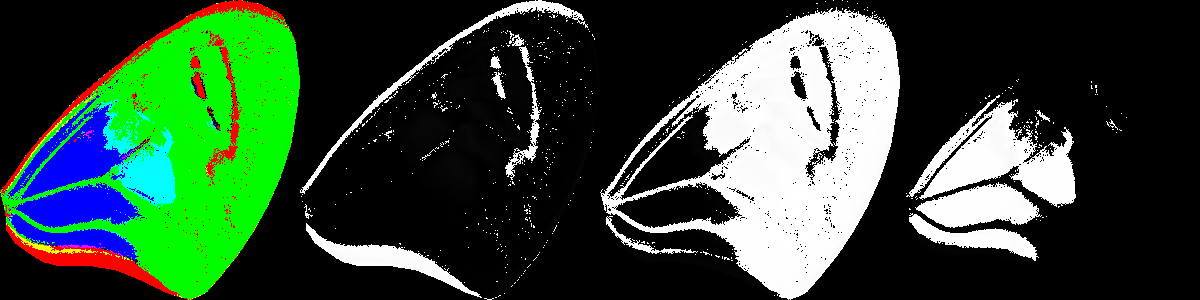

In [155]:
model_pca_vec = get_model_pca_view(test_model_input, test_camid)
model_img = get_proj_img(model_pca_vec, return_raw=True)

raw_to_images(model_img)

torch.Size([1, 1, 1931266, 3])


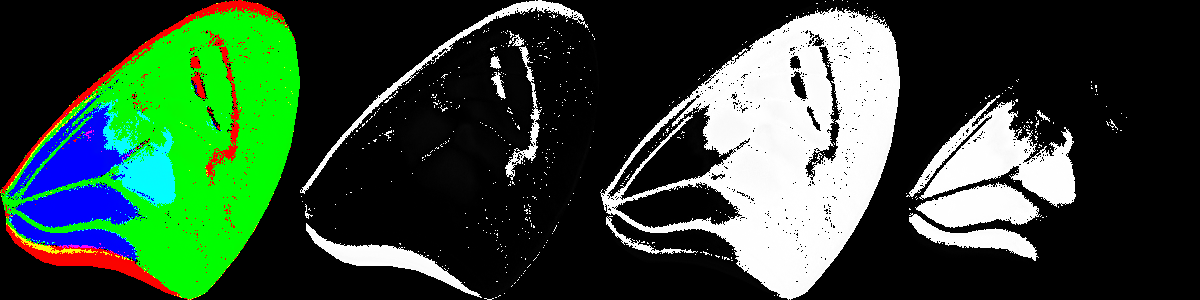

In [172]:
window_start = 386956
window_end = 387008
edit_value = "aa"

match edit_value:
    case "AA":
        edit_vec = torch.tensor([0, 0, 1])
    case "aa":
        edit_vec = torch.tensor([1, 0, 0])
    case "aA/Aa":
        edit_vec = torch.tensor([0, 1, 0])
    case _:
        edit_vec = torch.tensor([0, 0, 0])


edit_vec = edit_vec.unsqueeze(0).repeat(window_end - window_start, 1)
edit_input = test_model_input.detach().clone()
edit_input[0][0][window_start:window_end] = edit_vec
print(edit_input.shape)

model_edit_pca_vec = get_model_pca_view(edit_input, test_camid)
model_edit_img = get_proj_img(model_edit_pca_vec, return_raw=True)

raw_to_images(model_edit_img)

23.46255441959151
-0.0010696969893210229 0.0011111880653245088
-0.0011111880653245088 0.0010798156125009228
-0.0003586466844999192 0.000521050197503703


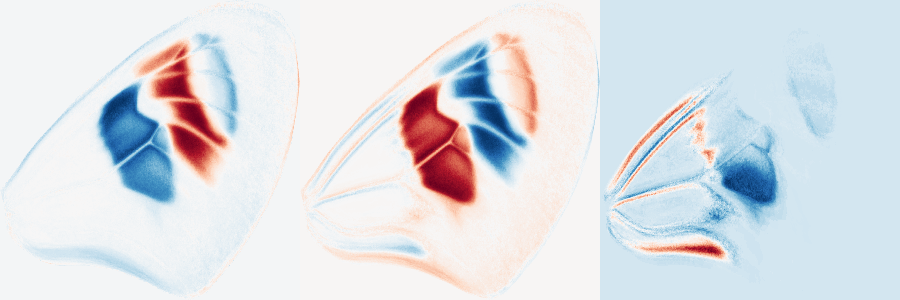

In [173]:
def get_diff_img(org, edit, normalize=False):
    diff_img = (np.array(org).astype(np.float64) - np.array(edit)).astype(np.float64)
    if len(diff_img.shape) == 3:
        diff_img = np.abs(diff_img).sum(-1)
    
    if normalize:
        diff_img -= diff_img.min()
        diff_img /= diff_img.max()


    diff_img = Image.fromarray(
        np.uint8(
            cm.jet(
                diff_img,
            )
            * 255
        )
    )

    return diff_img

def get_diff_imgs(org, edit, normalize=False):
    diff_img = (np.array(org).astype(np.float64) - np.array(edit)).astype(np.float64)
    print(np.abs(diff_img).sum())
    diff_imgs = []
    if normalize:
        for d in range(3):
            print(diff_img[:, :, d].min(), diff_img[:, :, d].max())
            diff_img[:, :, d] -= diff_img[:, :, d].min()
            diff_img[:, :, d] /= diff_img[:, :, d].max()


    for d in range(3):
        diff_imgs.append(
            np.uint8(
                cm.RdBu_r(
                    diff_img[:, :, d],
                )
                * 255
            )
        )

    diff_img = Image.fromarray(np.concatenate(diff_imgs, axis=1))

    return diff_img

diff_img_tmp = get_diff_imgs(model_img, model_edit_img, normalize=True)

diff_img_tmp

In [126]:
camids_test = np.load("../data/erato_test.npy")
camids_test.tolist()

['CAM016997',
 'CAM016752',
 'CAM016883',
 'CAM017042',
 'CAM016303',
 'CAM016022',
 'CAM016172',
 'CAM017418',
 'CAM016636',
 'CAM016559',
 'CAM017122',
 'CAM017441',
 'CAM016671',
 'CAM016456',
 'CAM016221',
 'CAM016513',
 'CAM016756',
 'CAM016590',
 'CAM016521',
 'CAM017168',
 'CAM016978',
 'CAM016464',
 'CAM017225',
 'CAM016924',
 'CAM016265',
 'CAM017320',
 'CAM016711',
 'CAM017191',
 'CAM017045',
 'CAM017002',
 'CAM017151',
 'CAM016651',
 'CAM016647',
 'CAM017340',
 'CAM016791',
 'CAM017206',
 'CAM016832',
 'CAM016740',
 'CAM016566',
 'CAM016736',
 'CAM017039',
 'CAM016582',
 'CAM017429',
 'CAM016231',
 'CAM016899',
 'CAM017297',
 'CAM016585',
 'CAM016194',
 'CAM017127']

In [127]:
from gtp.dataloading.tools import collect_chromosome_position_metadata
from gtp.dataloading.path_collectors import get_post_processed_genotype_directory

genotype_dir = get_post_processed_genotype_directory(experiment_state.configs.io)
dna_dir = genotype_dir / experiment_state.configs.experiment.genotype_scope
print(dna_dir)
position_metadata = collect_chromosome_position_metadata(
    dna_dir, experiment_state.species, experiment_state.chromosome
)

position_metadata[10]

/local/scratch/carlyn.1/dna/processed/genotypes/genome


['Herato1001', 682]

In [192]:
normalizing_constant = { # Obtained from the greated difference image at the peak attribution for each color
    "color_1" : 0.0015756611967540771,
    "color_2" : 0.0029504226500927213,
    "color_3" : 0.0008137173370284477,
    "color_total" : 0.004299188027193457
}

saved_positions = [
    (4_651_958, -139, 338), # base position, window left, window right
    (4_569_576, -20, 22), # Total Strongest
    (4_619_982, -101, 82),
    (4_583_043, -559, 432), # Control, should be noisy / bad
    (4_674_406, -134, 79),
    (4_674_406, -134, 79), # Color 3 Strongest
    (4_647_619, -223, 626), # Color 2 Strongest
    (4_651_658, -314, 161), # Color 1 Strongest
    (4_637_657, 0, 4_637_727 - 4_637_657), # 8 - Phenotype 1
    (4_639_853, 0, 4_641_535 - 4_639_853), # 9 - Phenotype 2
    (4_657_452, 0, 4_658_207 - 4_657_452), # 10 - Phenotype 3
    (4_666_909, 0, 4_670_474 - 4_666_909), # 11 - Phenotype 4
    (4_700_932, 0, 4_708_441 - 4_700_932), # 12 - Phenotype 5
    
    (4634681, 0, 4634700 - 4634681), # 13 - 7-In-Sd	SD-B
    (4634860, 0, 4634877 - 4634860), # 14 - 7-In-Sd	SD-A
    (4635132, 0, 4635151 - 4635132), # 15 - 7-In-Sd	SD-C
    (4635525, 0, 4635544 - 4635525), # 16 - 7-In-Sd	SD-D
    
    (4645632, 0, 4645650 - 4645632), # 17 - 8-In-St	WntA-ST2-gRNA1
    (4645503, 0, 4645522 - 4645503), # 18 - 8-In-St	WntA-ST2-gRNA-Y
    (4645649, 0, 4645668 - 4645649), # 19 - 8-In-St	WntA-ST2-gRNA-Z
    
    (4647368, 0, 4647387 - 4647368), # 20 - 9-In-St	ST1-A1
    (4647363, 0, 4647382 - 4647363), # 21 - 9-In-St	ST1-A2
    (4647197, 0, 4647216 - 4647197), # 22 - 9-In-St	ST1-A7
    (4647463, 0, 4647482 - 4647463), # 23 - 9-In-St	ST1-P2
    
    (4634681, 0, 4635544 - 4634681), # 24 - 7-In-Sd
    (4645503, 0, 4645668 - 4645503), # 25 - 8-In-St
    (4647197, 0, 4647482 - 4647197), # 26 - 9-In-St
]

saved_name = "tmp"
sp = saved_positions[24]

In [175]:
def float_to_uint_np(x):
    return (x * 255).astype(np.uint8)

In [201]:
from tqdm import tqdm
from pathlib import Path

image_save_path = Path("/local/scratch/carlyn.1/dna_proj_images", saved_name)


predicition_save_dir = image_save_path / "predictions"
edit_save_dir = image_save_path / "edits"
predicition_save_dir.mkdir(exist_ok=True, parents=True)
edit_save_dir.mkdir(exist_ok=True, parents=True)


base_position = sp[0]
window_start = base_position + sp[1]
window_end = base_position + sp[2]

with open(image_save_path / "dna_location.txt", 'w') as f:
    f.write(f"{window_start} -> {window_end}")

nominal_start = None
nominal_end = None
max_diff = 0
for i, (_, real_pos) in enumerate(position_metadata):
    if nominal_start is None:
        if real_pos < window_start:
            continue
        elif real_pos == window_start:
            nominal_start = i
            continue
        else:
            nominal_start = max(i-1, 0)
            continue
    elif nominal_end is None:
        if real_pos < window_end:
            continue
        elif real_pos == window_end:
            nominal_end = i
            break
        else:
            nominal_end = i
            break
    else:
        break
    
print(f"New window - nominal: ({nominal_start}, {nominal_end})")
print(f"New window - real: ({position_metadata[nominal_start][1]}, {position_metadata[nominal_end][1]})")

print(color)
if color == "color_total":
    zero_arr = np.zeros((300, 300, 3)).astype(np.float64)
else:
    zero_arr = np.zeros((300, 300)).astype(np.float64)
aggregated_diff = {
    "AA": zero_arr.copy(), "aA/Aa": zero_arr.copy(), "aa": zero_arr.copy(), "zero": zero_arr.copy(),
}
aggregated_pos_diff = {
    "AA": zero_arr.copy(), "aA/Aa": zero_arr.copy(), "aa": zero_arr.copy(), "zero": zero_arr.copy(),
}
aggregated_neg_diff = {
    "AA": zero_arr.copy(), "aA/Aa": zero_arr.copy(), "aa": zero_arr.copy(), "zero": zero_arr.copy(),
}
bad_camids = 0
#camids = experiment_state.camids
camids = camids_test

tbar = tqdm(camids, desc="Aggregating species edits", colour="#864E04")
for camid in tbar:
    org_pca_vec = get_org_pca_vector(camid)
    if org_pca_vec.shape[0] == 0:
        print(f"Skipping bad CAMID: {camid}")
        bad_camids += 1
        continue
    org_img = get_proj_img(org_pca_vec, return_raw=True)
    
    with torch.no_grad():
        model_input = get_model_input(camid)
        model_output = get_model_output(model_input)
        
        model_pca_vec = get_model_pca_view(model_input, camid)
        
        model_img_to_save = get_proj_img(model_pca_vec) 
        model_img_to_save.save(predicition_save_dir / f"{camid}.png")
        
        model_img = get_proj_img(model_pca_vec, return_raw=True)
        

        for edit_value in ["AA", "aA/Aa", "aa", "zero"]:
            match edit_value:
                case "AA":
                    edit_vec = torch.tensor([0, 0, 1])
                case "aa":
                    edit_vec = torch.tensor([1, 0, 0])
                case "aA/Aa":
                    edit_vec = torch.tensor([0, 1, 0])
                case _:
                    edit_vec = torch.tensor([0, 0, 0])

            edit_vec = edit_vec.unsqueeze(0).repeat(nominal_end - nominal_start, 1)
            edit_input = model_input.detach().clone()
            edit_input[0][0][nominal_start:nominal_end] = edit_vec

            model_edit_pca_vec = get_model_pca_view(edit_input, camid)
            model_edit_img = get_proj_img(model_edit_pca_vec, return_raw=True)
            
            diff_raw = model_img - model_edit_img
            
            pos_idx = diff_raw > 0
            
            pos_img = np.zeros_like(diff_raw)
            pos_img[pos_idx] = diff_raw[pos_idx].copy()
            
            neg_img = np.zeros_like(diff_raw)
            neg_img[~pos_idx] = diff_raw[~pos_idx].copy()
            neg_img = -neg_img
            
            diff_img = np.abs(diff_raw)
            
            #if len(diff_img.shape) == 3:
            #    diff_img = diff_img.sum(-1)
            #    pos_img = pos_img.sum(-1)
            #    neg_img = neg_img.sum(-1)
            
            max_diff = max(max_diff, diff_img.max())
            aggregated_diff[edit_value] += np.abs(diff_img)
            aggregated_pos_diff[edit_value] += np.abs(pos_img)
            aggregated_neg_diff[edit_value] += np.abs(neg_img)
            tbar.set_postfix({
                "max_diff" : max_diff,
                "pos_img_chng": pos_img.sum(),
                "neg_img_chng": neg_img.sum(),
                "img_chng_diff": pos_img.sum() - neg_img.sum()
            })
            
            model_edit_img_to_save = get_proj_img(model_edit_pca_vec)
            model_edit_img_to_save.save(edit_save_dir / f"{camid}_{edit_value.replace("/", '-')}.png")
        
            

print(max_diff)

New window - nominal: (386956, 387008)
New window - real: (4634653, 4635545)
color_total


Aggregating species edits: 100%|██████████| 49/49 [00:24<00:00,  1.97it/s, max_diff=0.00232, pos_img_chng=7.1, neg_img_chng=7.12, img_chng_diff=-0.0202]   

0.0023212207698408704


0.0014759521947399937
0.003501740352496052
0.0010836783695278047
0.0012317045183785223


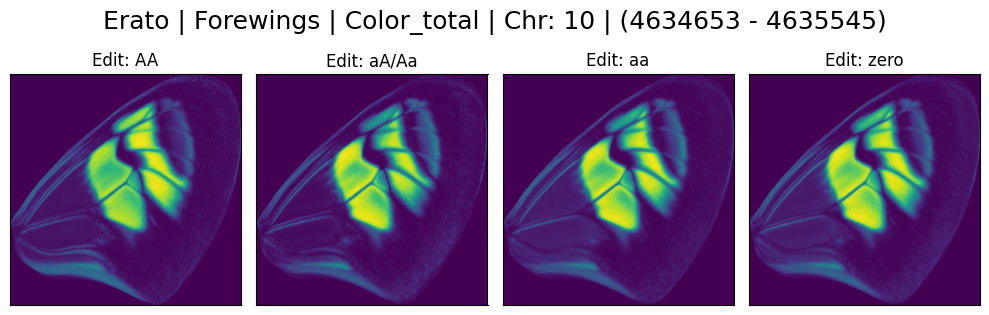

In [194]:
import matplotlib.pyplot as plt

#threshold = 0.0
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
for r, c, ev in [(0, 0, "AA"), (0, 1, "aA/Aa"), (0, 2, "aa"), (0, 3, "zero")]:
    num_imgs = (len(camids) - bad_camids)
    
    img_to_show = aggregated_diff[ev].copy()
    img_to_show = img_to_show.sum(-1)
    
    img_to_show /= num_imgs
    print(img_to_show.max())
    img_to_show /= img_to_show.max()
    #img_to_show /= normalizing_constant[color]
    im = axs[c].imshow(img_to_show, vmin=0, vmax=1)
    #im = axs[c].imshow(img_to_show)
    axs[c].set_title(f"Edit: {ev}")
    axs[c].set_xticks([])
    axs[c].set_yticks([])
    #cbar = plt.colorbar(im)

plt.tight_layout()
title_text = f"{species.capitalize()} | {wing.capitalize()} | {color.capitalize()} | Chr: {experiment_state.chromosome} | ({position_metadata[nominal_start][1]} - {position_metadata[nominal_end][1]})"
fig.suptitle(title_text, fontsize=18, y=0.68)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm

max_pos = 0
max_neg = 0
num_imgs = (len(camids) - bad_camids)
for r, c, ev in [(0, 0, "AA"), (0, 1, "aA/Aa"), (0, 2, "aa"), (0, 3, "zero")]:
    max_pos = max(aggregated_pos_diff[ev].max() / num_imgs, max_pos)
    max_neg = max(aggregated_neg_diff[ev].max() / num_imgs, max_neg)
    
total_max = max(max_pos, max_neg)
    
#threshold = 0.0
# Create a CenteredNorm object
norm = CenteredNorm(vcenter=0)
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))
for color_row in range(3):
    for r, c, ev in [(0, 0, "AA"), (0, 1, "aA/Aa"), (0, 2, "aa"), (0, 3, "zero")]:
        pos_img_to_show = aggregated_pos_diff[ev].copy()
        pos_img_to_show = pos_img_to_show[:, :, color_row]
        #pos_img_to_show -= pos_img_to_show.min()
        #pos_img_to_show /= pos_img_to_show.max()
        pos_img_to_show /= num_imgs
        pos_img_to_show /= max_pos
        #pos_img_to_show /= total_max
        pos_img_to_show /= pos_img_to_show.max()
        neg_img_to_show = aggregated_neg_diff[ev].copy()
        neg_img_to_show = neg_img_to_show[:, :, color_row]
        #neg_img_to_show -= neg_img_to_show.min()
        #neg_img_to_show /= neg_img_to_show.max()
        neg_img_to_show /= num_imgs
        neg_img_to_show /= max_neg
        #neg_img_to_show /= total_max
        neg_img_to_show /= neg_img_to_show.max()
        
        print(pos_img_to_show.max(), neg_img_to_show.max(), ev, total_max)
        
        #img_to_show = np.zeros(list(pos_img_to_show.shape) + [3])
        #img_to_show[:, :, 0] = pos_img_to_show
        #img_to_show[:, :, 2] = neg_img_to_show
        
        img_to_show = pos_img_to_show - neg_img_to_show
        #img_to_show = -neg_img_to_show
        
        img = axs[color_row, c].imshow(img_to_show, cmap='RdBu_r', norm=norm)
        img = axs[color_row, c].set_aspect("auto")
        #colorbar = fig.colorbar(img, ax=axs[color_row, c])
        
        #colorbar.set_label('Average Difference')
        if color_row == 0:
            axs[color_row, c].set_title(f"{ev}", fontsize=24, weight="bold")
        axs[color_row, c].set_xticks([])
        axs[color_row, c].set_yticks([])
        for side in ['top', 'bottom', 'right', 'left']:
            axs[color_row, c].spines[side].set_visible(False)
        #cbar = plt.colorbar(im)
        
        if c == 0:
            axs[color_row, c].set_ylabel(f"Color {color_row+1}", fontsize=18, weight="bold")
            
color_title = color if "total" not in color else "total"
            
title_text = f"{species.capitalize()} - {wing.capitalize()} | {color_title.capitalize()} | [{position_metadata[nominal_start][1]} - {position_metadata[nominal_end][1]}]"
fig.suptitle(title_text, fontsize=28, y=1.01, weight="bold")

plt.subplots_adjust(hspace=0.0, wspace=0.00)
plt.tight_layout(w_pad=0, h_pad=0.0)

plt.savefig(f"/home/carlyn.1/dna-trait-analysis/output/{saved_name}.svg", bbox_inches='tight')

plt.show()

NameError: name 'camids' is not defined